# ¿Cómo se comportan los viajes en taxi?
Tenemos una muestra de los datasets de una compañía de taxi: información de las compañías, las zonas de bajada y la duración de los viajes para algunos sábados. Queremos analizar los comportamientos de las primeras dos y poder usar la tercera para poder saber si existe una diferencia en el tiempo de recorrido cuando llueve en la ciudad: haremos una prueba de hipótesis para esto.

<b>Tabla de contenidos</b>

1. [Trabajo previo](#1)<br>
    1.1 [Importar librerías](#1.1)  
    1.2 [Trabajar con datos](#1.2)
2. [Análisis exploratorio](#2)<br>
    2.1 [Compañías-viajes](#2.1)<br>
    2.2 [Barrios de destino](#2.2)<br>
3. [Prueba de hipótesis](#3)<br>
4. [Conclusiones](#4)

### Trabajo previo
<a class="anchor" id="1"></a>
#### Importar librerías
<a class="anchor" id="1.1"></a>

In [264]:
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns

#### Trabajar con datos
<a class="anchor" id="1.2"></a>

##### Cargar los datos
<a class="anchor" id="1.2.1"></a>
Cargaremos los datos que tenemos y les echaremos un ojo para saber con que estamos trabajando.

In [265]:
# Cargamos
df_company = pd.read_csv("/datasets/project_sql_result_01.csv")
df_locs = pd.read_csv("/datasets/project_sql_result_04.csv")
df_trips = pd.read_csv("/datasets/project_sql_result_07.csv")

In [266]:
display(
    df_company.sample(n=10, random_state=1)
)

df_company.info()

,company_name,trips_amount
24,Chicago Taxicab,1014
39,0118 - 42111 Godfrey S. Awir,33
52,3721 - Santamaria Express,14
27,Service Taxi Association,402
44,2092 - 61288 Sbeih Company,27
2,Medallion Leasing,10367
21,American United,1404
62,2241 - 44667 - Felman Corp,3
41,Chicago Star Taxicab,29
50,2823 - 73307 Lee Express Inc,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Se ve bien, los datos no parecen tener vacíos y todo esta en su tipo correcto. Veamos que sucede con el otro dataset.

In [267]:
display(
    df_locs.sample(n=10, random_state=1)
)

df_locs.info()

,dropoff_location_name,average_trips
40,Bucktown,74.300000
31,Lower West Side,143.300000
45,Boystown,53.966667
86,West Elsdon,5.666667
83,Avalon Park,6.966667
48,Austin,44.433333
67,Auburn Gresham,15.166667
44,Belmont Cragin,59.033333
78,Gage Park,8.233333
74,Beverly,10.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


Igual se ve bien, parece que no tenemos que realizar ningún cambio sobre estos tampoco.

In [268]:
display(
    df_trips.sample(n=10, random_state=1)
)

df_trips.info()

,start_ts,weather_conditions,duration_seconds
457,2017-11-11 14:00:00,Good,2820.0
347,2017-11-11 17:00:00,Good,2460.0
639,2017-11-25 16:00:00,Good,2091.0
833,2017-11-04 07:00:00,Good,1440.0
437,2017-11-04 14:00:00,Good,3528.0
108,2017-11-25 08:00:00,Good,1277.0
599,2017-11-04 16:00:00,Bad,3180.0
186,2017-11-25 09:00:00,Good,1473.0
763,2017-11-11 06:00:00,Good,1320.0
201,2017-11-18 12:00:00,Bad,2571.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


Parece que solo es necesario cambiar _start_ts_ a un tipo de fecha.

In [269]:
# Convertamos a fecha
df_trips.start_ts = pd.to_datetime(df_trips.start_ts)
df_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 25.2+ KB


##### Verificar duplicados
<a class="anchor" id="1.2.2"></a>
Ya que parece que los datos están ahí, revisemos si existen algunos duplicados antes de continuar.

In [270]:
display(
    df_company[df_company.duplicated()]
)

display(
    df_trips[df_trips.duplicated()]
)

df_locs[df_locs.duplicated()]

,company_name,trips_amount


,start_ts,weather_conditions,duration_seconds
62,2017-11-11 06:00:00,Good,1260.0
74,2017-11-11 08:00:00,Good,1380.0
76,2017-11-04 09:00:00,Good,1380.0
117,2017-11-11 07:00:00,Good,1380.0
119,2017-11-04 14:00:00,Good,3300.0
...,...,...,...
1054,2017-11-11 07:00:00,Good,1380.0
1058,2017-11-25 12:00:00,Good,1440.0
1062,2017-11-11 06:00:00,Good,1500.0
1065,2017-11-11 13:00:00,Good,2100.0


,dropoff_location_name,average_trips


No tenemos ningún duplicado explícito en las columnas de barrios y compañías, pero si en la de los viajes, echemósle un ojo solo a estos, ordenando los datos.

In [271]:
# Usemos keep=False para ver todos, incluso el original duplicado
df_trips[df_trips.duplicated(keep=False)].sort_values("start_ts")

,start_ts,weather_conditions,duration_seconds
541,2017-11-04 05:00:00,Good,1200.0
462,2017-11-04 05:00:00,Good,1200.0
682,2017-11-04 06:00:00,Good,1267.0
681,2017-11-04 06:00:00,Good,1267.0
363,2017-11-04 07:00:00,Good,1440.0
...,...,...,...
831,2017-11-25 11:00:00,Good,1680.0
1058,2017-11-25 12:00:00,Good,1440.0
255,2017-11-25 12:00:00,Good,1380.0
53,2017-11-25 12:00:00,Good,1380.0


Aquí podríamos decir que tenemos duplicados al tener viajes iguales en tiempo y duración, pero no podemos estar seguro de eso: nótese que _start_ts_ va de hora en hora por lo que puede haber dos viajes similares en el mismo intervalo de tiempo y no serían duplicados.

Como tenemos valores numéricos en la tabla original, veamos como se distribuyen para remover los que no tengan sentido.

,start_ts,weather_conditions,duration_seconds
163,2017-11-11 09:00:00,Good,0.0
168,2017-11-11 07:00:00,Good,0.0
1063,2017-11-25 11:00:00,Good,0.0
204,2017-11-18 19:00:00,Good,0.0
552,2017-11-04 01:00:00,Good,0.0
...,...,...,...
79,2017-11-11 15:00:00,Good,4800.0
583,2017-11-11 16:00:00,Good,4980.0
276,2017-11-18 12:00:00,Bad,4980.0
619,2017-11-25 14:00:00,Good,6420.0


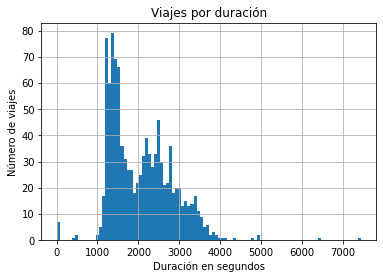

In [272]:
display(
    df_trips.sort_values("duration_seconds")
)

# El histograma
df_trips.duration_seconds.hist(bins=100)

plt.title("Viajes por duración")
plt.xlabel("Duración en segundos")
plt.ylabel("Número de viajes")
plt.show()

Interesante, pareciera que los valores suelen estar cerca de los ~1200 segundos, pero tenemos valores en cero: estos deben ser viajes cancelados, mejor los removemos.

In [273]:
# Removemos los valores
df_trips = df_trips.query("duration_seconds > 0")

df_trips.sort_values("duration_seconds")

,start_ts,weather_conditions,duration_seconds
15,2017-11-25 13:00:00,Good,60.0
424,2017-11-11 13:00:00,Good,420.0
203,2017-11-18 00:00:00,Bad,480.0
860,2017-11-04 18:00:00,Bad,480.0
874,2017-11-04 05:00:00,Good,1018.0
...,...,...,...
79,2017-11-11 15:00:00,Good,4800.0
583,2017-11-11 16:00:00,Good,4980.0
276,2017-11-18 12:00:00,Bad,4980.0
619,2017-11-25 14:00:00,Good,6420.0


### Análisis exploratorio
<a class="anchor" id="2"></a>

Exploraremos los datos que tenemos en nuestras tablas, empecemos con la tabla de las compañías.

#### Compañías-viajes
<a class="anchor" id="2.1"></a>
Tenemos cerca de 70 empresas de taxis, por lo que no podemos mostrar todos los valores: nos restringiremos solo a los primeros diez con más viajes y sumaremos estos en la categoría _Otros_.

,company_name,trips_amount,cumulative
0,Flash Cab,19558,19558
1,Taxi Affiliation Services,11422,30980
2,Medallion Leasing,10367,41347
3,Yellow Cab,9888,51235
4,Taxi Affiliation Service Yellow,9299,60534
5,Chicago Carriage Cab Corp,9181,69715
6,City Service,8448,78163
7,Sun Taxi,7701,85864
8,Star North Management LLC,7455,93319
9,Blue Ribbon Taxi Association Inc.,5953,99272


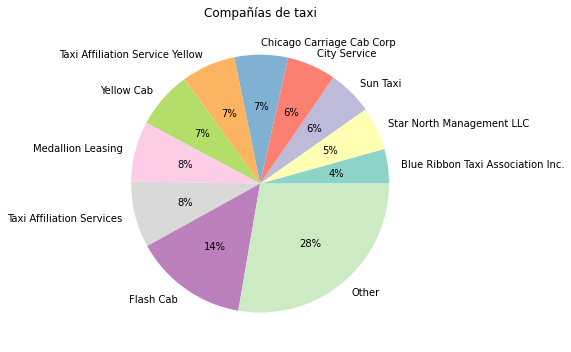

In [274]:
df_temp = df_company.sort_values(by="trips_amount", ascending=False).head(10)

# Agregamos todos los demás
df_temp = df_temp.append(
    {
        "company_name": "Other", "trips_amount": df_company.trips_amount.sum() - df_temp.trips_amount.sum()
    },
    ignore_index=True
)

df_temp["cumulative"] = df_temp.trips_amount.cumsum()

display(
    df_temp
)

# Graficamos
colors = sns.color_palette('Set3')

df_temp.groupby("company_name").sum().sort_values(by="trips_amount", ascending=True).plot(
    kind="pie", y = "trips_amount", autopct='%1.0f%%', legend=False, figsize=(20,5), colors = colors
)

plt.ylabel("")
plt.title("Compañías de taxi")
plt.tight_layout()
plt.show()

#df_temp.plot.pie(y="trips_amount")

Nótese que no hay ninguna compañía que domine el mercado por si sola, son muchas pequeñas que tienen una cuota del mercado. La más grande, _Flash Cab_, ni siquiera llega a ser la suma de las dos consiguientes. Hay bastante competencia y el mercado está disgregado.


#### Barrios de destino
<a class="anchor" id="2.2"></a>
Tenemos cerca de 100 destinos diferentes por lo que haremos lo mismo que hicimos para las compañías de taxis: nos quedaremos con las diez más concurridas y agruparemos el resto en Otro.

,dropoff_location_name,average_trips,cumulative
0,Loop,10727.466667,10727.466667
1,River North,9523.666667,20251.133333
2,Streeterville,6664.666667,26915.800000
3,West Loop,5163.666667,32079.466667
4,O'Hare,2546.900000,34626.366667
5,Lake View,2420.966667,37047.333333
6,Grant Park,2068.533333,39115.866667
7,Museum Campus,1510.000000,40625.866667
8,Gold Coast,1364.233333,41990.100000
9,Sheffield & DePaul,1259.766667,43249.866667


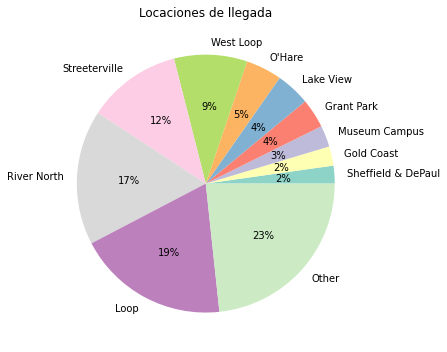

In [275]:
df_temp = df_locs.sort_values(by="average_trips", ascending=False).head(10)

# Agregamos otors
df_temp = df_temp.append(
    {
        "dropoff_location_name": "Other", "average_trips": df_locs.average_trips.sum() - df_temp.average_trips.sum()
    },
    ignore_index=True
)

df_temp["cumulative"] = df_temp.average_trips.cumsum()

display(
    df_temp
)

# Graficamos
colors = sns.color_palette('Set3')
df_temp.groupby("dropoff_location_name").sum().sort_values(by="average_trips", ascending=True).plot(
    kind="pie", y = "average_trips", autopct='%1.0f%%', legend=False, figsize=(20,5), colors = colors
)

plt.ylabel("")
plt.title("Locaciones de llegada")
plt.tight_layout()
plt.show()

Pasa algo similar a los resultados de las compañías: los valores están bien repartidos entre los destinos, pero aquí es un poco menos notable ya que Other es un valor cercano al de _Loop_ que es el más concurrido.

### Prueba de hipótesis
<a class="anchor" id="3"></a>

Queremos probar que "La duración promedio de los viajes desde el Loop hasta el Aeropuerto Internacional O'Hare cambia los sábados lluviosos". Esto se puede matematizar definiendo la hipótesis nula de que los promedios son iguales para ambas, $H_0: \mu_{good} = \mu_{bad}$; la hipótesis alternativa es $H_1 : \mu_{good} \neq \mu_{bad}$. Establezcamos una tolerancia $\alpha = 0.05$, para un intervalo de confianza de 95%.

Antes de hacer la prueba, veamos cuales son los valores mínimos y máximos de las fechas en la columna de _start_ts_ para darnos una idea de cuántos sábados tenemos y veamos que días tenemos (aparte de sábados).

In [276]:
print(
    f"El valor mínimo es {df_trips.start_ts.min()} y el máximo: {df_trips.start_ts.max()}"
)

El valor mínimo es 2017-11-04 00:00:00 y el máximo: 2017-11-25 23:00:00


In [277]:
#df_trips.start_ts.min().day_name()
display(
    df_trips.query("start_ts.dt.day_name() == 'Saturday'")
)

df_trips.start_ts.dt.day.unique()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1062,2017-11-11 06:00:00,Good,1500.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


array([25,  4, 11, 18])

Parece que solo tenemos valores para días sábado, así que no hay necesidad de filtrar la fecha, solo separaremos los valores que tienen Bad o Good en el clima y haremos una gráfica boxplot para ver como se comporta.

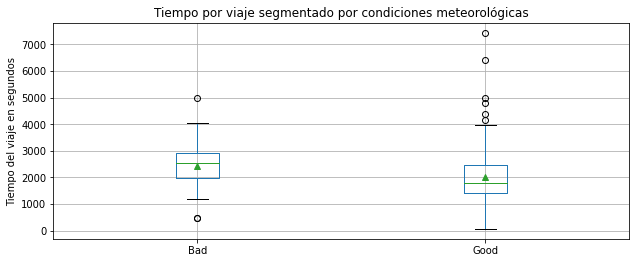

In [278]:
# Grafiquemos
df_trips.boxplot(column = "duration_seconds", by="weather_conditions", showmeans=True, figsize=(10,4))

plt.suptitle("")
plt.title("Tiempo por viaje segmentado por condiciones meteorológicas", fontsize=12.0, fontweight=400)
plt.xlabel("")
plt.ylabel("Tiempo del viaje en segundos")
plt.show()

#.boxplot(column = "sales_total", by="platform", ax=ax)#, showfliers=False)

De la gráfica se aprecia que el promedio es similar para tanto como _Bad_ y _Good_, pero no es igual. No podemos estar seguro hasta que hagamos nuestra prueba de hipótesis, pero primero haremos una prueba de Levene para saber si las varianzas son similares. 

In [279]:
# Tomemos días por clima
df_trips_good = df_trips.query("weather_conditions == 'Good'")
df_trips_bad = df_trips.query("weather_conditions == 'Bad'")

#Establecemos alpha
alpha = 0.05

result = st.levene(df_trips_good.duration_seconds, df_trips_bad.duration_seconds, center="mean")

# Prueba de Levene
print('p-valor:', result.pvalue)

if result.pvalue < alpha:
    print("Las varianzas no son similares.")
else:
    print("Las varianzas son apróximadamente similares.")

p-valor: 0.5149422013161751
Las varianzas son apróximadamente similares.


Con esto podemos ya proceder a la prueba de hipótesis con varianzas similares.

In [280]:
# Prueba para las plataformas
stat_result_hyp1 = st.ttest_ind(
    df_trips_good.duration_seconds,
    df_trips_bad.duration_seconds,
    equal_var=True
)
alpha = 0.05

print("El valor p es", stat_result_hyp1.pvalue)

if stat_result_hyp1.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")


El valor p es 1.3318772977743245e-11
Rechazamos la hipótesis nula


Como rechazamos la hipótesis nula (esto es, de que son iguales), podemos aventurarnos a decir que el tiempo de viaje cambia en días lluviosos. Esto es de esperarse: en días de mal clima el tránsito vehicular es peor.

### Conclusiones
<a class="anchor" id="4"></a>

Hicimos varias tareas: cargamos los datos de los barrios y las compañías, observando que el mercado esta bastante disperso pero que suelen haber algunos líderes punteros. Posteriormente hicimos una prueba de hipótesis para poder saber si la duración de los viajes de Loop al aeropuerto O'Hare cambia cuando llueve y podemos afirmar que si.